# 📓 Plan du notebook `02_preprocessing.ipynb`

| Étape | Titre de l'étape                                          | Objectif                                                                |
| ----- | --------------------------------------------------------- | ----------------------------------------------------------------------- |
| 1     | 🧪 Étape 1 – Redimensionnement & préparation des images   | Redimensionnement des images en 224x224 et stockage local               |
| 2     | 📦 Étape 2 – Extraction des features CNN avec ResNet50    | Passage des images par ResNet50 (sans classification) → vecteurs 2048-d |
| 3     | 🧩 Étape 3 – Chargement des features extraits (optionnel) | Visualisation de features d'une image pour vérif ou debug               |
| 4     | ✅ Étape 4 – Validation des features extraits              | Vérifie la présence des fichiers `.pt` pour chaque image attendue       |
| 5     | ✅ Étape 5 – Alignement features & captions                | Ne conserve que les captions ayant un fichier de features associé       |
| 6     | 🧾 Étape 6 – Vérification finale du dataset aligné        | Sauvegarde d’un JSON `aligned_captions.json` + affichage d’un exemple   |


## 🧪 Étape 1 – Redimensionnement & préparation des images

In [14]:
# 📦 Imports
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# 🔧 Configuration
raw_images_dir = Path("../data/raw/Flicker8k_Dataset")
augmented_dir = Path("../data/processed/augmented_images")
all_images_dir = list(raw_images_dir.glob("*.jpg")) + list(augmented_dir.glob("*.jpg"))

print(f"✅ Nombre total d’images (originales + augmentées) : {len(all_images_dir)}")


✅ Nombre total d’images (originales + augmentées) : 32364


#### 📌 Objectif :
- Convertir toutes les images en `RGB`

- Les redimensionner à la taille attendue par le backbone CNN

- Les sauvegarder dans `data/processed/resized_images`

- Souhaites-tu qu'on ajoute une visualisation de quelques exemples redimensionnés (`matplotlib`) avant de passer à l'étape 2 (extraction de features) ?

## 📦 Étape 2 – Extraction des features CNN avec ResNet50

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# ⚙️ Device (GPU si dispo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Dossiers
raw_images_dir = Path("../data/raw/Flicker8k_Dataset")
augmented_dir = Path("../data/processed/augmented_images")
features_dir = Path("../data/processed/features_resnet_global")
features_dir.mkdir(parents=True, exist_ok=True)

# 📋 Fusion des images originales et augmentées
image_files = list(raw_images_dir.glob("*.jpg")) + list(augmented_dir.glob("*.jpg"))
print(f"Nombre total d'images (originales + augmentées) à traiter : {len(image_files)}")

# 🧪 Prétraitement (Resize déjà fait dans l'augmentation)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 🧠 Modèle ResNet50 tronqué (on garde jusqu’au dernier avgpool)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval().to(device)

# 🔁 Boucle de traitement
for img_path in tqdm(image_files, desc="🔍 Extraction des features"):
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet(input_tensor)  # (1, 2048, 1, 1)
        features = features.squeeze().cpu()  # (2048,)

    # 💾 Sauvegarde avec le nom sans extension
    out_path = features_dir / f"{img_path.stem}.pt"
    torch.save(features, out_path)

print("✅ Extraction des features terminée.")


Nombre total d'images (originales + augmentées) à traiter : 32364


c:\Users\thoma\Desktop\cnn_lstm\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thoma\Desktop\cnn_lstm\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
🔍 Extraction des features: 100%|██████████| 32364/32364 [44:26<00:00, 12.14it/s] 

✅ Extraction des features terminée.


## 🧩 Étape 3 – Chargement des features extraits (optionnel, vérif visuelle ou debug)

Cette étape te permet de **vérifier rapidement** que les features `.pt` ont bien été extraits et stockés, et de charger quelques fichiers pour inspection.

In [1]:
import torch
from pathlib import Path

# 📂 Dossier contenant les features extraites
features_dir = Path("../data/processed/features_resnet_global")
feature_files = list(features_dir.glob("*.pt"))

print(f"✅ {len(feature_files)} fichiers de features trouvés dans {features_dir}")

# 🧠 Exemple : chargement d’un fichier pour inspection
example_path = feature_files[0]
features = torch.load(example_path)

print(f"🔍 Features extraites pour : {example_path.name}")
print("Shape des features :", features.shape)


✅ 32364 fichiers de features trouvés dans ..\data\processed\features_resnet_global
🔍 Features extraites pour : 1000268201_693b08cb0e.pt
Shape des features : torch.Size([2048])


## ✅ Étape 4 – Validation des features extraits

### 🔍 Vérification des shapes

In [2]:
from pathlib import Path
import torch

features_dir = Path("../data/processed/features_resnet_global")
feature_files = sorted(features_dir.glob("*.pt"))

invalid_files = []

for path in feature_files:
    try:
        tensor = torch.load(path)
        if tensor.shape != (2048,):
            invalid_files.append((path.name, tensor.shape))
    except Exception as e:
        invalid_files.append((path.name, str(e)))

if len(invalid_files) == 0:
    print("✅ Tous les fichiers de features sont valides (2048,)")
else:
    print(f"❌ {len(invalid_files)} fichier(s) invalide(s) détecté(s) :")
    for name, shape in invalid_files[:5]:
        print(f"  - {name} → {shape}")


✅ Tous les fichiers de features sont valides (2048,)


### 4️⃣ Optionnel – Visualisation d’un vecteur de features pour une image

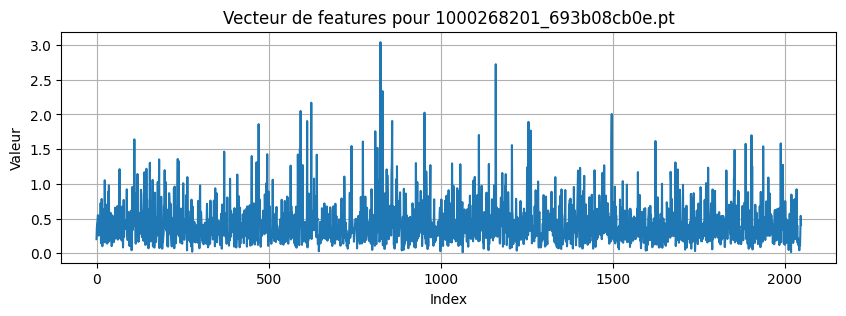

In [3]:
import matplotlib.pyplot as plt

# 🔢 Chargement d’un vecteur aléatoire
sample_path = feature_files[0]
sample_tensor = torch.load(sample_path)

plt.figure(figsize=(10, 3))
plt.plot(sample_tensor.numpy())
plt.title(f"Vecteur de features pour {sample_path.name}")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


### 5️⃣ Optionnel – Shape moyenne des features extraites

In [4]:
shapes = [torch.load(f).shape for f in feature_files]
shape_counts = {}

for shape in shapes:
    shape_counts[shape] = shape_counts.get(shape, 0) + 1

print("📊 Répartition des shapes :")
for shape, count in shape_counts.items():
    print(f"  - {shape}: {count} fichiers")

if len(shape_counts) == 1 and (2048,) in shape_counts:
    print("✅ Tous les vecteurs ont la même forme attendue.")
else:
    print("⚠️ Attention : certaines features ont des shapes différentes.")


📊 Répartition des shapes :
  - torch.Size([2048]): 32364 fichiers
✅ Tous les vecteurs ont la même forme attendue.


## ✅ Étape 5 – Alignement features & captions

### 📌 Objectif :
- Créer un dictionnaire propre : `{image_id: [captions]}`
- Uniquement pour les images dont les *features .pt* ont bien été extraites.

In [6]:
from collections import defaultdict
import os
from pathlib import Path

# 📂 Fichier des captions
captions_file = "../data/raw/Flickr8k_text/Flickr8k.token.txt"
features_dir = Path("../data/processed/features_resnet_global")

# 📋 Liste des IDs de features extraites (avec ou sans augmentation)
extracted_ids = {f.stem.split("_aug")[0] for f in features_dir.glob("*.pt")}

# 📚 Dictionnaire pour stocker les captions valides
aligned_captions = defaultdict(list)

# 🔁 Lecture et filtrage des captions correspondant à des images existantes
with open(captions_file, "r") as f:
    for line in f:
        try:
            image_tag, caption = line.strip().split('\t')
            image_id = image_tag.split('#')[0].split('.')[0]
            if image_id in extracted_ids:
                aligned_captions[image_id].append(caption.strip())
        except Exception as e:
            print(f"⛔ Problème avec la ligne : {line}")

# 🔍 Vérification rapide
print(f"✅ Captions valides pour {len(aligned_captions)} images")

example_id = next(iter(aligned_captions))
print(f"\n🧾 Exemple – {example_id}:")
for c in aligned_captions[example_id]:
    print("  ➤", c)


✅ Captions valides pour 8091 images

🧾 Exemple – 1000268201_693b08cb0e:
  ➤ A child in a pink dress is climbing up a set of stairs in an entry way .
  ➤ A girl going into a wooden building .
  ➤ A little girl climbing into a wooden playhouse .
  ➤ A little girl climbing the stairs to her playhouse .
  ➤ A little girl in a pink dress going into a wooden cabin .


### 💾 Optionnel : Sauvegarde en JSON

In [7]:
import json

with open("../data/processed/aligned_captions.json", "w") as f:
    json.dump(aligned_captions, f, indent=2)

print("💾 Fichier `aligned_captions.json` sauvegardé avec indentation.")


💾 Fichier `aligned_captions.json` sauvegardé avec indentation.


## 🧾 Étape 6 – Vérification finale du dataset aligné

Avant de passer à l'étape de création du `Dataset` PyTorch, on vérifie simplement la cohérence du fichier `aligned_captions.json`.

In [8]:
with open("../data/processed/aligned_captions.json", "r") as f:
    aligned = json.load(f)

print(f"🔢 Nombre d'images alignées : {len(aligned)}")
example_id = next(iter(aligned))
print(f"🖼️ Exemple : {example_id}")
for caption in aligned[example_id]:
    print("  ➤", caption)


🔢 Nombre d'images alignées : 8091
🖼️ Exemple : 1000268201_693b08cb0e
  ➤ A child in a pink dress is climbing up a set of stairs in an entry way .
  ➤ A girl going into a wooden building .
  ➤ A little girl climbing into a wooden playhouse .
  ➤ A little girl climbing the stairs to her playhouse .
  ➤ A little girl in a pink dress going into a wooden cabin .
